# Table of Contents
* Rules and Conditions
* Exponential Distribution RNG
* Particle Initialztion
* Plots
* Diagnostic

# [Electron Cascade Physics](http://hst-archive.web.cern.ch/archiv/HST2000/teaching/expt/muons/cascades.htm)
## Ionization: 
* Charged particles lose 2 $\frac{MeV*cm^2}{g}$ or 22 $\frac{MeV}{cm}$ in Pb
* Energy is lost to medium

## Pair Production: 
* if $E_{\gamma}$ > 1 MeV then  $\gamma$ -> $e^-$ + $e^+$ 
* All energy from photon goes to electron / positron
* Dominates at Low energies
 

## Bremsstrahlung: 
* e --> e + $\gamma$
* Electron loses fraction of energy to produce photon
* Dominates at High energies
* Given by E(x) = $E_{0}$ $\exp$($\frac{x}{x_{0}}$)

## Defined Quantities

#### Critical Energy: 
* Energy where Ionization loss = Bremsstrahlung loss
* $E_{c}$ = 6.9 Mev in lead

#### Radiation Length: 
* Distance such that average energy loss to bremsstrahlung decreases particle energy by $\frac{1}{e}$
* $X_{0}$ = 5.8 $\frac{g}{cm^2}$ in Pb
* $X_{0}$ = 5.6 mm in Pb

# Rules:
1.  1D cascade along x-axis
2.  Brem: Pick distance x from exp dist with
$\lambda$(rate) = $\frac{1}{X_{0}}$ Creates photon with Energy = $\frac{x}{x_{0}}$. Must be above critical energy

3. Pair-Production: Pick distance x from exp distribution with $\lambda$(rate) = $\frac{7}{9X_{0}}$ Energy is evenly split. Must have energy > 1 MeV 
4. Charged particles lose energy 
2$\frac{MeV*cm^2}{g}$ or 2.2 $\frac{MeV}{mm}$ 

# Goal

Plot histogram of average number of charged particles vs depth

In [2]:
%pylab
from __future__ import division
%matplotlib inline
np.set_printoptions(precision=4,linewidth=80)
import time

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Exponential Distribution Generation
Inverse Transform Sampling from Uniform Distribution

In [18]:
def expRand(size, rate, seed):
        #np.random.seed(seed)
        uniran = np.random.uniform(0.0,1.0, size)
        a = lambda t: np.log(1-t) / (-rate)
        expval = np.vectorize(a)
        expran = expval(uniran)
        return expran

## Particle Object

In [191]:
class particle(object):
    particles = []
    nParticles = 0
    radLen = 5.8
    radLen_mm = 5
    dx = 1
    time = 0
    
    def __init__(self, pid, energy, x, ptype, parentID, expRate, seed):
        self.name = pid
        self.initialenergy = energy
        self.energy = energy
        self.startPoint = x 
        self.x = x
        self.path = [self.x]
        self.ptype = ptype
        self.parentID = parentID
        self.splitDist = expRand(1, expRate, seed)[0] 
        self.nsteps = 0
        self.counted = True
        
    
    def __str__(self):
        return "Particle {0:2}--{1} | Energy = {2:06.2f} MeV | X = {3:05.2f} " \
               "| Alive: {4:5} | Escaped: {5:5} | Child of {6}".format(
             self.name, self.ptype, self.energy, self.x, str(self.alive),
              str(self.escaped), self.parentID )
 
    @property
    def splitDist_mm(self):
        return self.splitDist 
    
    @property
    def splitPoint(self):
        return self.splitDist_mm + self.startPoint
    
    @property
    def distUntilSplit(self):
        return self.splitPoint - self.x
    
    @property
    def alive(self):
        if self.energy > 0:
            return True
        else:
            if(self.counted and self.ptype is "e"):
                self.counted = False
                particle.nParticles -= 1
            return False
    
    @property
    def escaped(self):
        if self.x <= 50:
            return False
        else:
            if(self.counted and self.ptype is "e"):
                self.counted = False
                particle.nParticles -= 1
            return True
        
    def move(self):
        particle.time += 1
        self.nsteps += 1
        self.x += self.dx
        self.path.append(self.x)


class electron(particle):
    ionlossRate = 2 * particle.radLen / 11   
    critEnergy = 6.9 #MeV
    bremExpRate = 1/particle.radLen_mm

    def __init__(self, pid, energy, x, parentID, seed):
        particle.__init__(self, pid, energy, x, "e", parentID, electron.bremExpRate, seed)
        self.seed = seed
        particle.particles.append(self)
        particle.nParticles += 1
   
    def ionization(self):
        ionization = electron.ionlossRate * particle.dx
        if self.energy < ionization:
            self.energy = 0
        else:
            self.energy -= ionization    
    
    def bremmstrahlung(self):
        if(self.distUntilSplit < 1 and self.energy > electron.critEnergy):
            deltaEnergy = self.energy*(1 - np.exp(-self.splitDist / particle.radLen_mm))
            self.energy = self.energy * np.exp(-self.splitDist / particle.radLen_mm) 
            photon(len(particle.particles), deltaEnergy, 
                   self.x-1, self.name, self.seed + self.nsteps)
            
    def move(self):
        if(self.alive is True and self.escaped is False):
            if(self.distUntilSplit < 1):
                self.x += self.distUntilSplit
                self.bremmstrahlung()
                self.bremNewDist()
                self.nsteps += 1
            else:
                particle.move(self)
            self.ionization()
        else:
             pass
        
            
    def bremNewDist(self):
        self.seed += 1
        self.startPoint = self.x
        self.splitDist = expRand(1, electron.bremExpRate, self.seed)[0]
    

class photon(particle):
    mfp = (9/7) * particle.radLen_mm #g/cm^2 #mean free path 
    ppRate = 1 / mfp
    
    def __init__(self, pid, energy, x, parentID, seed):
        particle.__init__(self, pid, energy, x, "p", parentID, photon.ppRate, seed)
        self.seed = seed
        particle.particles.append(self)
    
    def pairproduction(self):
        if(self.distUntilSplit < 1 and self.energy > 1):
            for i in range(2):
                electron(len(particle.particles), .5*self.energy, 
                         self.x-1, self.name, self.seed + self.nsteps)
            self.energy = 0
            
    def move(self):
        if(self.alive and self.escaped is False):
            if(self.distUntilSplit < 1):
                self.x += self.distUntilSplit
                self.pairproduction()
                self.nsteps += 1
            else:
                particle.move(self)
        else:
            pass
            
def runtime(n):
    for i in range(n):
        electron(i, 1000, 0, 0, 1)
    npart = np.empty(0)
    while particle.nParticles>0:
        npart = np.append(npart, particle.nParticles)
        for i in particle.particles:
            if i.alive:
                i.move()
    return npart

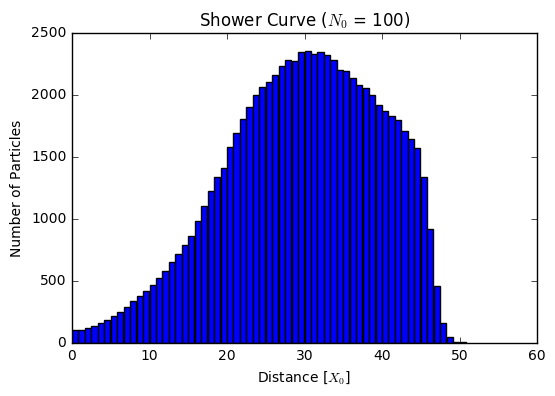

In [192]:
npart = runtime(100)
figure(1)
x = linspace(0,50,len(npart))
plt.bar(x, npart)
plt.title("Shower Curve ($N_{0}$ = 100)")
plt.xlabel("Distance [$X_{0}$]")
plt.ylabel("Number of Particles")
del npart

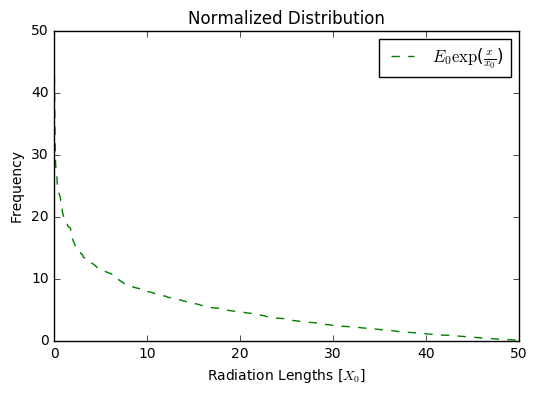

In [179]:
figure(2)
x = linspace (0,50,1000)
y1 = np.sort(expRand(1000, electron.bremExpRate, 1000))[::-1]
plot(x, y1, 'b--' ,label=r'Psuedo-Random')
plot(x, y2, 'g--',label=r'$E_{0}$$\exp$($\frac{x}{x_{0}}$)')
plt.legend()
plt.title("Normalized Distribution")
plt.xlabel("Radiation Lengths [$X_{0}$]")
plt.ylabel("Frequency")

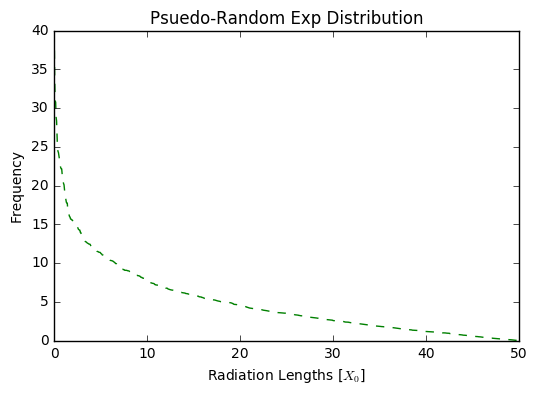

In [202]:
figure(1)
x = linspace (0,50,1000)
y1 = np.sort(expRand(1000, electron.bremExpRate, 1000))[::-1]
plot(x, y1, 'g--')
plt.legend()
plt.title("Psuedo-Random Exp Distribution")
plt.xlabel("Radiation Lengths [$X_{0}$]")
plt.ylabel("Frequency")

In [ ]:

plt.hist(splitdist, np.arange(55), histtype='bar', color='Red', label='Electrons')


# Plots

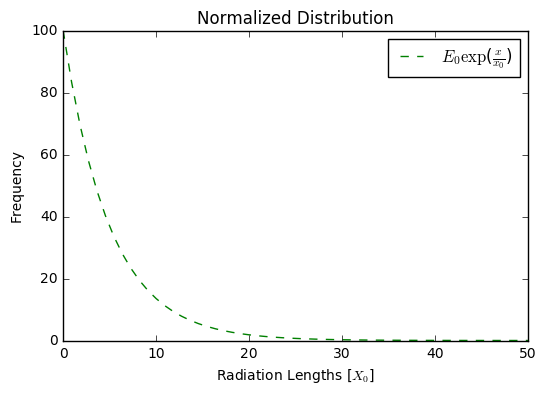

In [90]:
plt.figure()
#plt.hist(eDistRad, bins, histtype='bar', normed=1, color='Red', label='Electrons')

y1 = 100* exp(-x / electron.radLen_mm)
plot(x, y1, 'g--',label=r'$E_{0}$$\exp$($\frac{x}{x_{0}}$)')
plt.legend()
plt.title("Normalized Distribution")
plt.xlabel("Radiation Lengths [$X_{0}$]")
plt.ylabel("Frequency")

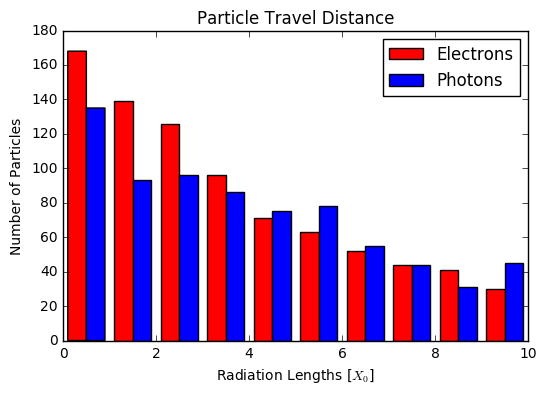

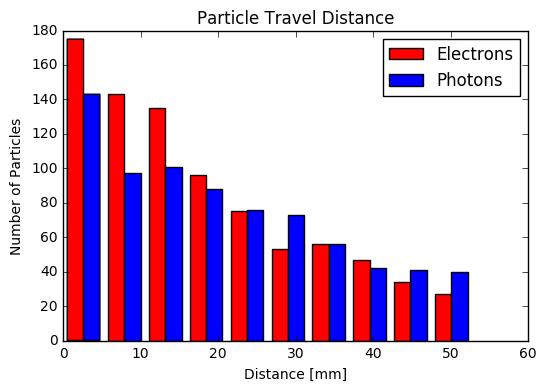

NameError: name 'bremRate' is not defined

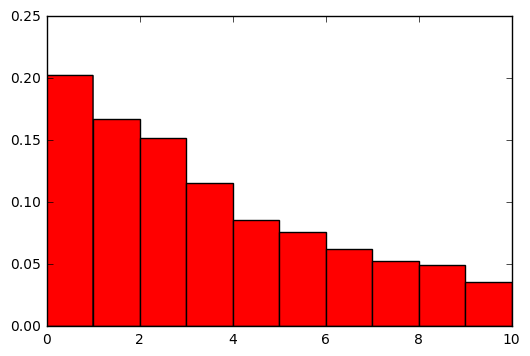

In [203]:
x = linspace(0,10)
bins=arange(0,11,1)
binsCM=bins[:] * (5.8*10/11)
#
plt.figure()
plt.hist([eDistRad,pDistRad], bins, histtype='bar', color=['Red','Blue'], label=['Electrons','Photons'])
plt.legend()
plt.title("Particle Travel Distance")
plt.xlabel("Radiation Lengths [$X_{0}$]")
plt.ylabel("Number of Particles")
plt.show()
#
plt.figure()
plt.hist([eDistCM,pDistCM], binsCM, histtype='bar', color=['Red','Blue'], label=['Electrons','Photons'])
plt.legend()
plt.title("Particle Travel Distance")
plt.xlabel("Distance [mm]")
plt.ylabel("Number of Particles")
plt.show()
#
plt.figure()
plt.hist(eDistRad, bins, histtype='bar', normed=1, color='Red', label='Electrons')
y1 = bremRate* exp(-x * bremRate)
plot(x, y1, 'g--',label=r'$E_{0}$$\exp$($\frac{x}{x_{0}}$)')
plt.legend()
plt.title("Normalized Distribution")
plt.xlabel("Radiation Lengths [$X_{0}$]")
plt.ylabel("Frequency")
#
plt.figure()
plt.hist(pDistRad, bins, histtype='bar', normed=1, color='Blue', label='Photons')
y2 = ppRate * exp(-x * ppRate )
plot(x, y2, 'g--',label=r'$E_{0}$$\exp$($\frac{7x}{9x_{0}}$)')
plt.legend()
plt.title("Normalized Distribution")
plt.xlabel("Ra7diation Lengths [$X_{0}$]")
plt.ylabel("Frequency")
#
legend(loc='upper right')
plt.show()


## Particle Initialization

In [138]:
nparticle=1000
eDistRad = expRand(nparticle, electron.bremExpRate, 1) #in radlens
eDistCM = eDistRad[:] * 5
pDistRad = expRand(nparticle, photon.ppRate  , 1)   #in radlens
pDistCM = pDistRad[:] * 5

# Energy Loss of particle